<hr>

https://www.tensorflow.org/datasets/catalog/fashion_mnist

https://github.com/zalandoresearch/fashion-mnist

Fashion-MNIST is a dataset of clothing images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [1]:
import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    from tensorflow.keras.datasets import fashion_mnist
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers
    from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

flabels = {0 : 't-shirt',
           1 : 'trousers',
           2 : 'pullover',
           3 : 'dress',
           4 : 'coat',
           5 : 'sandal',
           6 : 'shirt',
           7 : 'sneaker',
           8 : 'bag',
           9 : 'boot'}

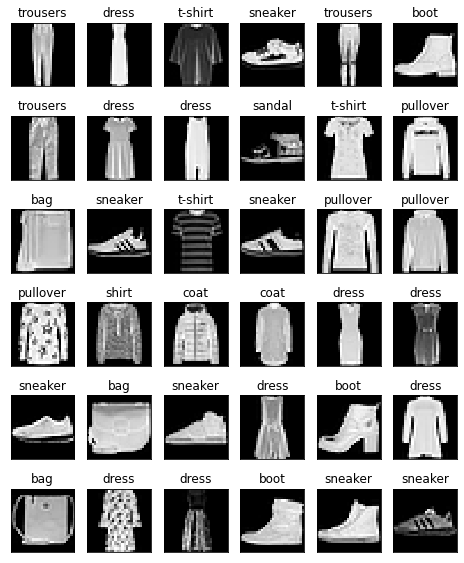

In [2]:
# display some images with their labels
fig = plt.figure(figsize=(8, 10))
N = 6
st_idx = R.randint(0, train_images.shape[0]-N*N-1)
for i in range(N*N):
    plt.subplot(N,N,i+1)
    plt.imshow(train_images[st_idx+i], cmap='gray', interpolation='none')
    plt.title(flabels[train_labels[st_idx+i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Q1a: Autoassociator

Note on Homework 7 that for the autoencoder (Q1a), you should use linear activation functions on the outputs (as a regression-type problem). For this, I've asked you to have it develop PCA-like representations, which means also using linear activation functions on the hidden layer. With a regression-type problem, mean_squared_error is an appropriate loss function

(I just realized that the autoencoder code I shared in Homework 1 used a nonlinear hidden layer, which is fine but not PCA-like, had sigmoidal output activations, which is ok since the pixel values are normalized to fall between 0 and 1, but had an inappropriate objective function - I think I copied that code from someplace at one time and hadn't bothered to check it closely since it was just a quick demo to make sure Keras/Tensorflow was working.)

In [3]:
def plot_model_loss(history):
    """Loss Plotting Function"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss As a Function of Number of Epochs Trained')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    
def plot_model_accuracy(history):
    """Accuracy Plotting Function"""
    plt.plot(history.history['acc'])
    plt.title('Model Accuracy As a Function of Number of Epochs Trained')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

In [4]:
# Reshape the training images to be a flattened 2D representation
new_dim = train_images.shape[1] * train_images.shape[2]
train_2D = np.reshape(train_images, (train_images.shape[0], new_dim))

# Expand the training labels to be 2D
train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))

# Shuffle all vector (THE SAME ORDER)
shuffled_idx = R.permutation(train_2D.shape[0])
train_shuffled = train_2D[shuffled_idx,:]
train_labels_shuffled = train_labels[shuffled_idx,:]

# Take half of the above for the training data for Q1a
train_half = train_shuffled[0:train_shuffled.shape[0]//2]
train_labels_half = train_labels_shuffled[0:train_shuffled.shape[0]//2]

train_imagesREMAKE_shuffled = np.reshape(train_shuffled, (train_shuffled.shape[0],28,28))

In [11]:
def generate_aa(encoding_dim, act1, act2, loss_func, train_half, train_half_labels, my_epochs=20, my_batch=256):
    # this is our input placeholder
    input_img = layers.Input(shape=(new_dim,))
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_dim, activation=act1)(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(new_dim, activation=act2)(encoded)

    # this model maps an input to its reconstruction
    autoencoder = models.Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = models.Model(input_img, encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = layers.Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = models.Model(encoded_input, decoder_layer(encoded_input))

    # compile model
    autoencoder.compile(optimizer='adam', loss=loss_func, metrics=['accuracy'])

    assert(train_half.shape[0] == train_labels_half.shape[0])
    assert(train_labels_half.shape[1] == 1)

    # My code here
    x_train = train_half[0:int(train_half.shape[0]*0.8), :]
    x_test = train_half[int(train_labels_half.shape[0]*0.8):, :]

    x_train = x_train / np.amax(train_half)
    x_test = x_test / np.amax(train_half)

    assert(x_test.shape[0] + x_train.shape[0] == train_half.shape[0])

    history = autoencoder.fit(x_train, x_train,
                    epochs=my_epochs,
                    batch_size=my_batch,
                    verbose = False,
                    shuffle=True,
                    validation_data=(x_test, x_test))

    plot_model_loss(history)
    
    return autoencoder, history

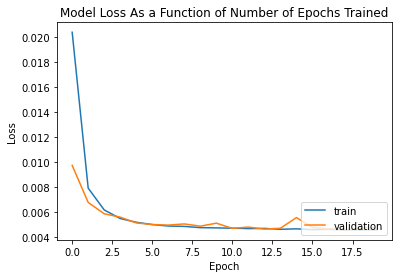

In [17]:
encoding_dim = 200
aa200, aahistory = generate_aa(encoding_dim, 'linear', 'linear', 'mean_squared_error', train_half, train_labels_half, my_batch=30)

In order to get the results above, I tried a number of different encoding dimensions (e.g. what the network should be compressed down to).  Given that the input dimension is 784 to begin with, I assumed that anything greater than half of that would be a pointless dimensionality reduction (e.g. not must use out of reducing the dimensionality down to 90% of the original size).  This gave an upper bound of ~350.  I also saw the PCA Example code, in which the MNIST digits were compressed from 784 down to 40; in this case, since we are using clothing not just digits, and clothing has more features (e.g. not just an outline / line), 40 established the absolute lower bound.  Through trial and error, I found that epochs should be below 40 and that batch size above ~200 made for "shaky" models in that there were not smooth loss curves.  I also noticed, as one might assume, that the more the dimensionality was reduced, the greater the loss.  Going from 40 to 80 takes the loss from 0.014 to 0.010, whereas 80 to 160 takes the loss from 0.010 to 0.006.  Thus, doubling the number of dimensions results in just less than a 50% performance boost in terms of loss, and more specifically this function is exponential decay and thus exhibits diminishing marginal returns for each amount that we increase the number of dimensions by.  Thus, I took the "elbow point" which looked to be around about 200.

## Q1b
> Use the remaining half of the original set as inputs to train a densely connected multilayer NN that learns, via backpropagation to classify the images.

1. Pick the proper activiation functions n the hidden units
2. Pick the proper activation function on the output units for a classificaiotn network
3. Make sure you also pick a proper loss function for a classification network

--> Multiclass classification: Relu, softmax, categorical_cross_entropy

In [39]:
def create_network(node_list, func_list=['relu'], my_opt='adam', loss_func='categorical_crossentropy'):
    network = models.Sequential()
        
    for idx, arg in enumerate(node_list):
        if idx == 0:
            n_prev = arg
        elif idx == len(node_list)-1:
            my_func = 'softmax'
            network.add(layers.Dense(arg, 
                             activation=my_func, 
                             input_shape=(n_prev,)))
        else:
            network.add(layers.Dense(arg, 
                                     activation=func_list[0], 
                                     input_shape=(n_prev,)))
    
    # configure optimizer
    # sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)
    network.compile(optimizer=my_opt, 
                    loss=loss_func, 
                    metrics=['accuracy', 'mse'])
    
    return network

In [40]:
train_half2 = train_shuffled[train_shuffled.shape[0]//2:]
train_labels_half2 = train_labels_shuffled[train_shuffled.shape[0]//2:]

print(train_half2.shape)
print(train_labels_half2.shape)

(30000, 784)
(30000, 1)


In [41]:
aanetwork = aa200
aanetwork.summary()

aaW = aanetwork.layers[1].get_weights()[0]
aab = aanetwork.layers[1].get_weights()[1]

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_16 (Dense)             (None, 200)               157000    
_________________________________________________________________
dense_17 (Dense)             (None, 784)               157584    
Total params: 314,584
Trainable params: 314,584
Non-trainable params: 0
_________________________________________________________________


In [59]:
backprop_network = create_network(node_list=[encoding_dim,30,40,10])
backprop_network.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 30)                6030      
_________________________________________________________________
dense_34 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_35 (Dense)             (None, 10)                410       
Total params: 7,680
Trainable params: 7,680
Non-trainable params: 0
_________________________________________________________________


In [79]:
def apply_weights(aaW, aab, inputs):
    x = np.matmul(inputs, aaW) + aab
    # Linear activation function implies "no" activation function
    return x

# y = mx + b
# fixed_inputs = W * original_inputs + b

print(train_half2.shape)
fixed_input = apply_weights(aaW, aab, train_half2)
print(fixed_input.shape)

# need to categorically encode the labels as "one hot"
train_labels_half2RE = to_categorical(train_labels_half2)

(30000, 784)
(30000, 200)


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 120)               24120     
_________________________________________________________________
dense_91 (Dense)             (None, 50)                6050      
_________________________________________________________________
dense_92 (Dense)             (None, 10)                510       
Total params: 30,680
Trainable params: 30,680
Non-trainable params: 0
_________________________________________________________________


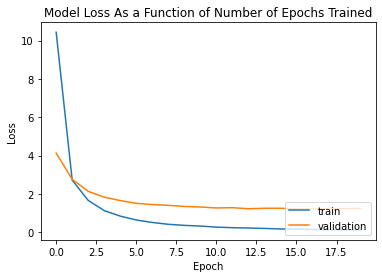

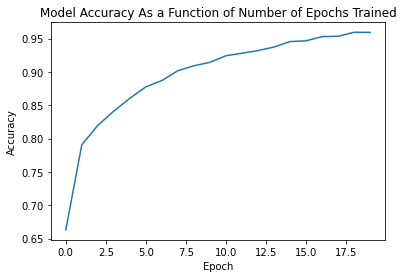

0.9594167


In [88]:
backprop_network = create_network(node_list=[encoding_dim,120,50,10])
backprop_network.summary()

history2 = backprop_network.fit(fixed_input, 
                              train_labels_half2RE, 
                              verbose=False, 
                              validation_split=.2, 
                              epochs=my_epochs, 
                              batch_size=my_batch)

plot_model_loss(history2)
plot_model_accuracy(history2)
print(history2.history['acc'][-1])

The final model of 200 x 120 x 50 x 10 was chosen after iterating through a number of options.  Of course, using a higher number of hidden layer and nodes increase the performance.  However, increasing the number of layers still required that each layer have at least around 100ish nodes or adding an additional layer would simply decrease performance: thus adding an arbitrary number of layers was not a good design and furthermore adding more layers, even when used to increase perfomance, required a large number of nodes to be included.  Additionally, it was observed that using a first layer with less than 100 nodes resulted in performances less than 90%.  Doing a number of iterations revealed that the given model performaned the best when controlling for the number of nodes (e.g. for a constant number of nodes, this combination of layers and nodes per layer out performed other architectures).  Performance can easily reach upwards of 99% if more hidden nodes are used.

## Q2: Use a CNN to Classify the Fashion MNIST

1. padding='valid'
    1. ^This is the default. It stays inside the previous layer
    2. 'same' --> Goes outside previous layer --> This is what we "may want to use"
2.  strides=(1,1)
    1. ^(default) convolution full covers previous layer
    2. Usually use full stride
    3. strides=(2,2) has gaps

In [107]:
network = models.Sequential()

# first convolution layer parameters
num_fm_1 = 16
conv_dim = 3
input_sz = 28
# second convolution layer parameters
num_fm_2 = 16
# max pooling parameters
mp_dim = 2
nout = 10

# first convolution layer
network.add(layers.Conv2D(num_fm_1, (conv_dim, conv_dim), 
                          activation='relu', 
                          input_shape=(input_sz, input_sz, 1)))
# second convolution layer
network.add(layers.Conv2D(num_fm_2, (conv_dim, conv_dim)))
# max pooling
network.add(layers.MaxPooling2D(mp_dim, mp_dim))

network.add(layers.Conv2D(16, (3,3), activation='relu'))
network.add(layers.MaxPooling2D((2,2)))
network.add(layers.Flatten())
network.add(layers.Dense(20, activation='relu'))
network.add(layers.Dense(nout, activation='softmax'))

In [108]:
network.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 24, 24, 16)        2320      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 10, 10, 16)        2320      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_132 (Dense)            (None, 20)              

In [109]:
network.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])

In [121]:
# Reformat images to be "4D"
train_imagesRE = train_images.reshape(train_images.shape[0], input_sz, input_sz, 1)
test_imagesRE = test_images.reshape(test_images.shape[0], input_sz, input_sz, 1)

# check out dimensions and types of mnist data
print('Training labels shape: ', train_labels.shape)
print('Training labels type:  ', type(train_labels[0]))
print()

# check out what the first 9 labels look like
print("First 9 training labels as labels:\n", train_labels[:9])
print()

# need to categorically encode the labels as "one hot"
train_labelsRE = to_categorical(train_labels)
test_labelsRE = to_categorical(test_labels)

print("First 9 training labels as one-hot encoded vectors:\n", train_labelsRE[:9])

Training labels shape:  (60000, 1)
Training labels type:   <class 'numpy.ndarray'>

First 9 training labels as labels:
 [[9]
 [0]
 [0]
 [3]
 [0]
 [2]
 [7]
 [2]
 [5]]

First 9 training labels as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [125]:
# Normalize
me = train_imagesRE/255
you = test_imagesRE/255

train_imagesRE = me
test_imagesRE = you

In [111]:
history = network.fit(train_imagesRE, train_labelsRE, verbose=True,
                      validation_split=.2, epochs=20, batch_size=256)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 20s 423us/sample - loss: 2.0789 - acc: 0.3909 - val_loss: 1.3791 - val_acc: 0.5153
Epoch 2/20
48000/48000 [==============================] - 20s 407us/sample - loss: 1.1866 - acc: 0.5934 - val_loss: 0.9606 - val_acc: 0.7097
Epoch 3/20
48000/48000 [==============================] - 20s 415us/sample - loss: 0.8616 - acc: 0.7303 - val_loss: 0.7506 - val_acc: 0.7498
Epoch 4/20
48000/48000 [==============================] - 22s 459us/sample - loss: 0.6797 - acc: 0.7527 - val_loss: 0.6167 - val_acc: 0.7437
Epoch 5/20
48000/48000 [==============================] - 23s 475us/sample - loss: 0.5786 - acc: 0.7616 - val_loss: 0.5482 - val_acc: 0.7717
Epoch 6/20
48000/48000 [==============================] - 22s 463us/sample - loss: 0.5242 - acc: 0.7896 - val_loss: 0.5088 - val_acc: 0.8027
Epoch 7/20
48000/48000 [==============================] - 23s 476us/sample - loss: 0.4820 - acc: 0.8144 

In [112]:
test_loss, test_accuracy = network.evaluate(test_imagesRE, test_labelsRE)

10000/10000 [==============================] - 2s 206us/sample - loss: 0.3768 - acc: 0.8768


In [113]:
print('test_acc:', test_accuracy)

test_acc: 0.8768


In [114]:
network = models.Sequential()
# first convolution layer parameters
num_fm_1 = 16
conv_dim = 3
input_sz = 28
# second convolution layer parameters
num_fm_2 = 16
# max pooling parameters
mp_dim = 2
nout = 10
# first convolution layer
network.add(layers.Conv2D(num_fm_1, (conv_dim, conv_dim), 
                          activation='relu', 
                          input_shape=(input_sz, input_sz, 1)))
# max pooling
network.add(layers.MaxPooling2D(mp_dim, mp_dim))

# second convolution layer
network.add(layers.Conv2D(num_fm_2, (conv_dim, conv_dim)))
# max pooling
network.add(layers.MaxPooling2D(mp_dim, mp_dim))

network.add(layers.Conv2D(16, (1,1), activation='relu'))
network.add(layers.Conv2D(16, (3,3), activation='relu'))
network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Flatten())
network.add(layers.Dense(20, activation='relu'))
network.add(layers.Dense(nout, activation='softmax'))

network.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])
network.summary()

history = network.fit(train_imagesRE, train_labelsRE, verbose=True,
                      validation_split=.2, epochs=20, batch_size=256)

test_loss, test_accuracy = network.evaluate(test_imagesRE, test_labelsRE)

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 11, 11, 16)        2320      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 5, 5, 16)          272       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 3, 3, 16)          2320      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 1, 1, 16)        

In [126]:
network = models.Sequential()
# first convolution layer parameters
num_fm_1 = 16
conv_dim = 3
input_sz = 28
# second convolution layer parameters
num_fm_2 = 16
# max pooling parameters
mp_dim = 2
nout = 10
# first convolution layer
network.add(layers.Conv2D(num_fm_1, (conv_dim, conv_dim), 
                          activation='relu', 
                          input_shape=(input_sz, input_sz, 1)))
# max pooling
network.add(layers.MaxPooling2D(mp_dim, mp_dim))

# second convolution layer
network.add(layers.Conv2D(num_fm_2, (conv_dim, conv_dim)))
# max pooling
network.add(layers.MaxPooling2D(mp_dim, mp_dim))

network.add(layers.Conv2D(24, (3,3), activation='relu'))
network.add(layers.Conv2D(24, (3,3), activation='relu'))

network.add(layers.Conv2D(24, (1,1), activation='relu'))

network.add(layers.Flatten())
network.add(layers.Dense(20, activation='relu'))
network.add(layers.Dense(nout, activation='softmax'))

network.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])
network.summary()

history = network.fit(train_imagesRE, train_labelsRE, verbose=True,
                      validation_split=.2, epochs=20, batch_size=256)

test_loss, test_accuracy = network.evaluate(test_imagesRE, test_labelsRE)

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 11, 11, 16)        2320      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 3, 3, 24)          3480      
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 1, 1, 24)          5208      
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 1, 1, 24)        

In [129]:
input_shape = train_imagesRE.shape

network = models.Sequential()
network.add(layers.Conv2D(32, (3,3),
                   activation='relu',
                   input_shape=input_shape))
network.add(layers.Conv2D(64, (3,3), activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2,2)))
network.add(layers.Dropout(0.25))
network.add(layers.Flatten())
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])
network.summary()

history = network.fit(train_imagesRE, train_labelsRE, verbose=True,
                      validation_split=.2, epochs=20, batch_size=256)

test_loss, test_accuracy = network.evaluate(test_imagesRE, test_labelsRE)

ValueError: Input 0 of layer conv2d_71 is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: [None, 60000, 28, 28, 1]